In [1]:
import shutil
from os import path
import os
import json

# Define the folder locations of source and destination datasets
SRC_DIR = "/kaggle/input/dentalai-dataset"  # Source dataset folder
DEST_DIR = "yolo_dataset"  # Destination dataset folder

# Step 1: Create folder structure of destination dataset
os.makedirs(path.join(DEST_DIR, "train", "images"), exist_ok=True)
os.makedirs(path.join(DEST_DIR, "train", "labels"), exist_ok=True)
os.makedirs(path.join(DEST_DIR, "val", "images"), exist_ok=True)
os.makedirs(path.join(DEST_DIR, "val", "labels"), exist_ok=True)
os.makedirs(path.join(DEST_DIR, "test", "images"), exist_ok=True)
os.makedirs(path.join(DEST_DIR, "test", "labels"), exist_ok=True)

# Step 2: Generate the data.yaml file
meta = json.load(open(path.join(SRC_DIR, "meta.json")))
classes = {}
for index, entry in enumerate(meta["classes"]):
    classes[entry["title"]] = index

# Create the "data.yaml" file in the destination dataset
with open(path.join(DEST_DIR, "data.yaml"), "w") as fp:
    fp.write("train: ../train/images\n")
    fp.write("val: ../val/images\n")
    fp.write("test: ../test/images\n")
    fp.write("\n")
    fp.write("nc: {}\n".format(len(classes)))
    fp.write("names: ['{}']\n".format("','".join(classes.keys())))

# Step 3: Copy images from source to destination datasets
dirs_map = {"train": "train", "valid": "val", "test": "test"}

for src_dir, dest_dir in dirs_map.items():
    # Copy all images from source to destination dataset
    shutil.copytree(path.join(SRC_DIR, src_dir, "img"),
                    path.join(DEST_DIR, dest_dir, "images"),
                    dirs_exist_ok=True)

    # Step 4: Convert annotations
    for file in os.listdir(path.join(SRC_DIR, src_dir, "ann")):
        ann = json.load(open(path.join(SRC_DIR, src_dir, "ann", file), "r"))
        
        # Get width and height of the image
        img_width = ann["size"]["width"]
        img_height = ann["size"]["height"]
        
        # Prepare name for the destination annotation file
        file_name = file.replace(".jpg.json", ".txt")
        with open(path.join(DEST_DIR, dest_dir, "labels", file_name), "w") as fp:
            
            for obj in ann["objects"]:
                class_id = classes[obj["classTitle"]]
                
                # Initialize bounding box coordinates
                top = float('inf')
                left = float('inf')
                bottom = float('-inf')
                right = float('-inf')

                # Calculate bounding box from polygon points
                for point in obj["points"]["exterior"]:
                    x, y = point
                    left = min(left, x)
                    right = max(right, x)
                    top = min(top, y)
                    bottom = max(bottom, y)

                # Calculate width and height
                width = right - left
                height = bottom - top
                
                # Calculate normalized values
                x_center = (left + width / 2) / img_width
                y_center = (top + height / 2) / img_height
                width /= img_width
                height /= img_height
                
                # Write to the destination annotation file
                fp.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

print("Conversion completed successfully!")


Conversion completed successfully!


In [2]:
pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.2/887.2 kB 11.0 MB/s eta 0:00:0000:010:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import necessary libraries
from ultralytics import YOLO
import os
import wandb

# Initialize Weights and Biases (W&B) for training phase
wandb.init(project="Caries_Detector", name="YOLOv8_Training_Experiment")

# Log hyperparameters to W&B
wandb.config.update({
    "epochs": 30,
    "batch_size": 16,
    "img_size": 640,
    "model_type": "YOLOv8m"
})


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [6]:
# Import necessary libraries
from ultralytics import YOLO
import os
import wandb

# Step 1: Initialize Weights and Biases (W&B) for experiment tracking
wandb.init(project="Caries_Detector", name="YOLOv8_Training_Experiment")

# Log hyperparameters and classes to W&B
wandb.config.update({
    "epochs": 30,
    "batch_size": 16,
    "img_size": 640,
    "model_type": "YOLOv8m",
    "classes": ["tooth detection", "caries detection", "dental crack", "dental cavity"]
})

# Step 2: Load the YOLOv8 model
model = YOLO("yolov8m.pt")  # Load the YOLOv8 medium model

# Path to dataset YAML file
data_yaml_path = os.path.join(os.getcwd(), "/kaggle/working/yolo_dataset/data.yaml")  # Update to your YAML file path

# Step 3: Train the Model
model.train(
    data=data_yaml_path,          # Path to the dataset YAML file
    epochs=wandb.config.epochs,   # Number of epochs
    batch=wandb.config.batch_size,  # Batch size
    imgsz=wandb.config.img_size,    # Input image size
    project="Caries_Detector",      # W&B project name
    name="YOLOv8_Training",         # Experiment name
    save_period=1                   # Save model weights every epoch
)

# Step 4: Save the Best Model Weights
best_weights_path = "runs/train/YOLOv8_Training/weights/best.pt"  # Path to best weights
wandb.save(best_weights_path)

# Save the trained model explicitly
trained_model_path = "yolov8_trained_model.pt"
model.save(trained_model_path)
wandb.log({"trained_model_path": trained_model_path})

# Step 5: Finish W&B Logging
wandb.finish()


Ultralytics 8.3.33 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/kaggle/working/yolo_dataset/data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=1, cache=False, device=None, workers=8, project=Caries_Detector, name=YOLOv8_Training3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True,

train: Scanning /kaggle/working/yolo_dataset/train/labels.cache... 1991 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1991/1991 [00:00<?, ?it/s]

train: WARNING ⚠️ /kaggle/working/yolo_dataset/train/images/804_jpg.rf.d6fb1371223a94b6caaaab80cd7aaac7.jpg: 1 duplicate labels removed
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/yolo_dataset/val/labels.cache... 254 images, 0 backgrounds, 0 corrupt: 100%|██████████| 254/254 [00:00<?, ?it/s]


Plotting labels to Caries_Detector/YOLOv8_Training3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to Caries_Detector/YOLOv8_Training3
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      13.6G     0.8208      1.003      1.061        130        640: 100%|██████████| 125/125 [01:12<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]

                   all        254       3156      0.426      0.365      0.317       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      12.8G     0.8211     0.6905      1.052        117        640: 100%|██████████| 125/125 [01:09<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        254       3156      0.372      0.352      0.326       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      12.7G      0.841      0.681      1.059        148        640: 100%|██████████| 125/125 [01:08<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]

                   all        254       3156      0.347      0.385      0.329      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      12.9G     0.8242     0.6585      1.055        131        640: 100%|██████████| 125/125 [01:08<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.72it/s]

                   all        254       3156      0.449      0.357      0.348      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      12.8G     0.8029     0.6324      1.045        129        640: 100%|██████████| 125/125 [01:08<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        254       3156      0.412      0.423      0.376      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      12.5G     0.7842     0.6164      1.036        165        640: 100%|██████████| 125/125 [01:08<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.78it/s]

                   all        254       3156      0.452        0.4      0.382      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      12.8G     0.7789      0.593      1.035        170        640: 100%|██████████| 125/125 [01:08<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.69it/s]

                   all        254       3156       0.53      0.386      0.372      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      12.8G     0.7604     0.5729      1.021        142        640: 100%|██████████| 125/125 [01:08<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]

                   all        254       3156      0.402      0.447      0.385      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      12.8G     0.7563     0.5627      1.017        109        640: 100%|██████████| 125/125 [01:08<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

                   all        254       3156      0.414      0.397      0.374      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      12.7G     0.7485     0.5544      1.014        113        640: 100%|██████████| 125/125 [01:08<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.66it/s]

                   all        254       3156      0.541      0.416      0.408      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      12.7G     0.7435     0.5435      1.013        125        640: 100%|██████████| 125/125 [01:08<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        254       3156      0.653      0.391      0.411      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      12.8G     0.7262     0.5269      1.001        120        640: 100%|██████████| 125/125 [01:08<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]

                   all        254       3156      0.522      0.418       0.42      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      12.6G     0.7067     0.5141     0.9954        154        640: 100%|██████████| 125/125 [01:08<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]

                   all        254       3156      0.522      0.467      0.459       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      12.8G     0.7068     0.4994     0.9899        105        640: 100%|██████████| 125/125 [01:08<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.74it/s]

                   all        254       3156      0.574      0.415      0.416       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30        13G     0.7124     0.5088     0.9977        143        640: 100%|██████████| 125/125 [01:08<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.77it/s]

                   all        254       3156      0.578      0.431      0.449      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      12.8G     0.6971     0.4988     0.9878        122        640: 100%|██████████| 125/125 [01:08<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.68it/s]

                   all        254       3156      0.501      0.445      0.437      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      12.8G     0.6822     0.4791     0.9811        207        640: 100%|██████████| 125/125 [01:08<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]

                   all        254       3156      0.492      0.436      0.443      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      12.9G     0.6758     0.4758     0.9759        146        640: 100%|██████████| 125/125 [01:08<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.78it/s]

                   all        254       3156      0.471      0.472      0.438      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      12.9G     0.6786     0.4686      0.978        166        640: 100%|██████████| 125/125 [01:08<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.77it/s]

                   all        254       3156      0.434      0.461      0.426      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      12.9G     0.6687     0.4583     0.9726        142        640: 100%|██████████| 125/125 [01:08<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.89it/s]

                   all        254       3156      0.517      0.476      0.458      0.318


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      12.9G     0.6541     0.4473     0.9579         89        640: 100%|██████████| 125/125 [01:09<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]

                   all        254       3156      0.628      0.444      0.459      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      12.8G     0.6461     0.4387     0.9567         60        640: 100%|██████████| 125/125 [01:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.61it/s]

                   all        254       3156      0.576      0.448       0.46      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30        13G     0.6365     0.4279     0.9422         92        640: 100%|██████████| 125/125 [01:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.82it/s]

                   all        254       3156      0.514      0.513      0.478      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      12.9G     0.6281     0.4161     0.9483         92        640: 100%|██████████| 125/125 [01:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.89it/s]

                   all        254       3156       0.56      0.453      0.467      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      12.9G     0.6205      0.406     0.9395         66        640: 100%|██████████| 125/125 [01:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.71it/s]

                   all        254       3156      0.518      0.489      0.467      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      12.7G     0.6144     0.3949     0.9361         82        640: 100%|██████████| 125/125 [01:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.85it/s]

                   all        254       3156      0.701      0.465      0.491      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30        13G     0.6079     0.3857      0.936         60        640: 100%|██████████| 125/125 [01:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.76it/s]

                   all        254       3156      0.611      0.461       0.49      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      12.9G     0.5988     0.3758     0.9285         94        640: 100%|██████████| 125/125 [01:07<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]

                   all        254       3156      0.629      0.499      0.493      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      12.9G     0.5895     0.3732     0.9211         80        640: 100%|██████████| 125/125 [01:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.77it/s]

                   all        254       3156      0.667      0.468      0.502      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      12.8G     0.5862     0.3615     0.9177         91        640: 100%|██████████| 125/125 [01:07<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.86it/s]

                   all        254       3156      0.599      0.514      0.507      0.352



30 epochs completed in 0.626 hours.
Optimizer stripped from Caries_Detector/YOLOv8_Training3/weights/last.pt, 52.0MB
Optimizer stripped from Caries_Detector/YOLOv8_Training3/weights/best.pt, 52.0MB

Validating Caries_Detector/YOLOv8_Training3/weights/best.pt...
Ultralytics 8.3.33 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 218 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.49it/s]


                   all        254       3156      0.599      0.513      0.506      0.351
                Caries        102        328      0.468      0.338      0.303      0.136
                Cavity         85        159      0.495      0.421      0.416      0.209
                 Crack         12         16      0.581      0.312       0.33      0.193
                 Tooth        254       2653      0.852      0.978      0.974      0.868
Speed: 0.2ms preprocess, 7.6ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to Caries_Detector/YOLOv8_Training3


trained_model_path,yolov8_trained_model...


In [13]:
def test_model(model_path, image_paths):
    import matplotlib.pyplot as plt
    from PIL import Image, ImageDraw

    # Load the trained model
    model = YOLO(model_path)

    # Prepare visualization
    fig, axs = plt.subplots(len(image_paths), 1, figsize=(10, 5 * len(image_paths)))

    if len(image_paths) == 1:
        axs = [axs]  # Ensure axs is iterable if only one image is provided

    for i, image_path in enumerate(image_paths):
        # Load image
        img = Image.open(image_path)

        # Perform detection
        results = model(image_path)

        # Extract bounding boxes and labels
        boxes = results[0].boxes
        detected_boxes = []
        for box in boxes:
            class_id = int(box.cls.cpu().numpy())  # Class index
            class_name = results[0].names[class_id]  # Class name
            confidence = float(box.conf.cpu().numpy())  # Confidence score
            box_coords = box.xyxy.cpu().numpy()[0]  # Ensure correct array indexing
            
            # Convert coordinates to integers
            box_coords = [int(coord) for coord in box_coords]
            
            # Append the detection
            detected_boxes.append((class_name, confidence, box_coords))

        # Draw bounding boxes on image
        draw = ImageDraw.Draw(img)
        for class_name, confidence, box_coords in detected_boxes:
            draw.rectangle(box_coords, outline="#00FF00", width=3)
            draw.text(
                (box_coords[0], box_coords[1] - 10), 
                f"{class_name}: {confidence:.2f}", 
                fill="white"
            )

        # Plot results
        axs[i].imshow(img)
        axs[i].set_title(f"Detections for {os.path.basename(image_path)}")
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()



image 1/1 /kaggle/working/yolo_dataset/test/images/1047_jpg.rf.b989b65e4e86d4738757caa25e11fd86.jpg: 448x640 1 Cavity, 1 Tooth, 28.3ms
Speed: 3.3ms preprocess, 28.3ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


/tmp/ipykernel_30/223067645.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_id = int(box.cls.cpu().numpy())  # Class index
/tmp/ipykernel_30/223067645.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(box.conf.cpu().numpy())  # Confidence score



image 1/1 /kaggle/working/yolo_dataset/test/images/2915_jpg.rf.c3f888a3734813d637782191c8e44c4c.jpg: 512x640 2 Cariess, 1 Crack, 4 Tooths, 45.9ms
Speed: 2.4ms preprocess, 45.9ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /kaggle/working/yolo_dataset/test/images/2642_jpg.rf.39a27997f01d2f33c63986bf2fe47679.jpg: 320x640 10 Tooths, 51.0ms
Speed: 1.2ms preprocess, 51.0ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


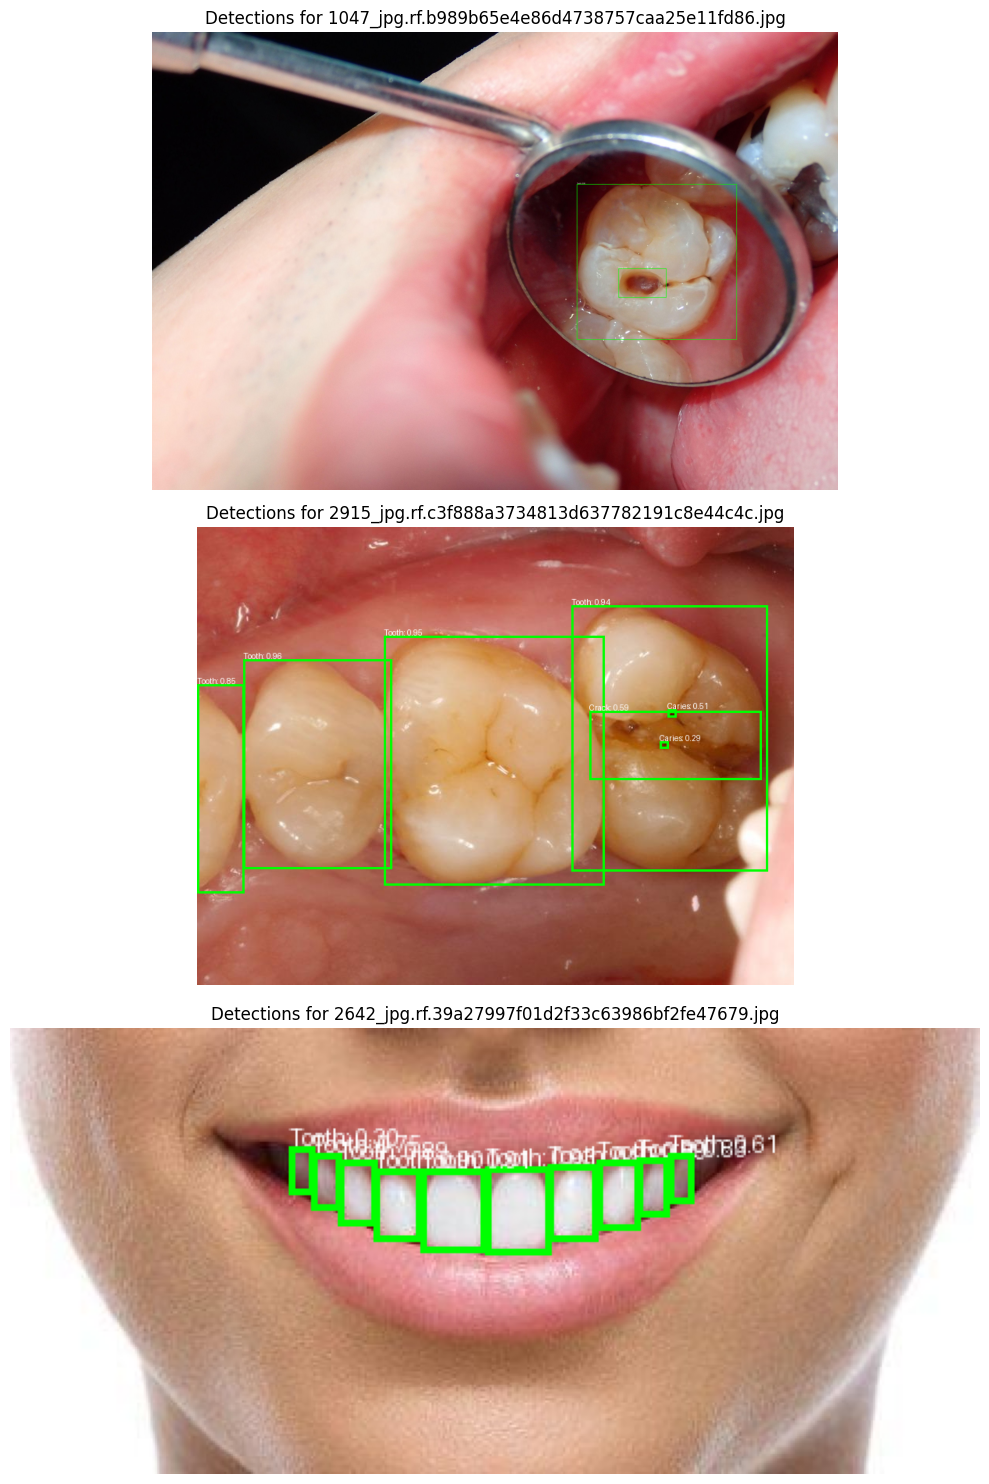

In [15]:
# Specify image paths
image_paths = [
    "/kaggle/working/yolo_dataset/test/images/1047_jpg.rf.b989b65e4e86d4738757caa25e11fd86.jpg",
    "/kaggle/working/yolo_dataset/test/images/2915_jpg.rf.c3f888a3734813d637782191c8e44c4c.jpg",
    "/kaggle/working/yolo_dataset/test/images/2642_jpg.rf.39a27997f01d2f33c63986bf2fe47679.jpg"
]

# Test the model
test_model("/kaggle/working/yolov8_trained_model.pt", image_paths)



image 1/1 /kaggle/input/test-image/external.jpg: 384x640 2 Cariess, 2 Tooths, 25.9ms
Speed: 1.5ms preprocess, 25.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


/tmp/ipykernel_30/3494859264.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_id = int(box.cls.cpu().numpy())  # Class index
/tmp/ipykernel_30/3494859264.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  confidence = float(box.conf.cpu().numpy())  # Confidence score


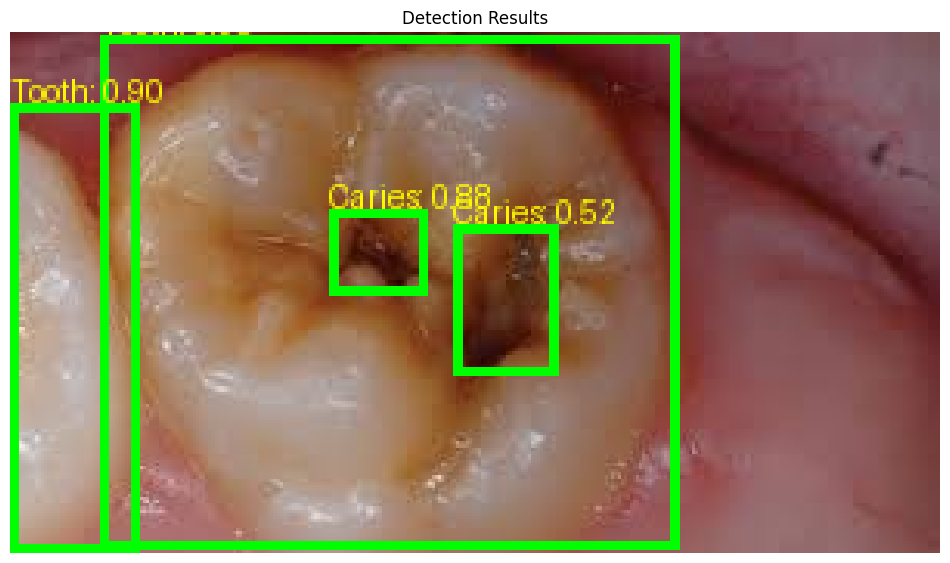

In [19]:
from ultralytics import YOLO
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# Load the trained model
model = YOLO("/kaggle/working/yolov8_trained_model.pt")  # Path to your trained model weights

def preprocess_image(image_path, target_size=(640, 640)):
    """
    Preprocess the input image to match YOLOv8's requirements.
    Resize and normalize the image.
    """
    img = Image.open(image_path).convert("RGB")  # Convert to RGB
    img_resized = img.resize(target_size)       # Resize to target size
    return img_resized

def predict_and_visualize(model, image_path):
    """
    Perform prediction on an external image and visualize the results.
    """
    # Open the original image
    img = Image.open(image_path).convert("RGB")

    # Perform inference
    results = model.predict(source=image_path, conf=0.5)  # Adjust confidence threshold as needed
    
    # Extract predictions
    detections = results[0]
    detected_boxes = []
    for box in detections.boxes:
        class_id = int(box.cls.cpu().numpy())  # Class index
        class_name = results[0].names[class_id]  # Class name
        confidence = float(box.conf.cpu().numpy())  # Confidence score
        
        # Bounding box coordinates (x_min, y_min, x_max, y_max)
        box_coords = box.xyxy.cpu().numpy().flatten()  # Flatten the tensor to extract coordinates
        box_coords = [int(coord) for coord in box_coords]  # Convert to integers
        detected_boxes.append((class_name, confidence, box_coords))
    
    # Draw bounding boxes on the image
    draw = ImageDraw.Draw(img)
    for class_name, confidence, box_coords in detected_boxes:
        draw.rectangle(box_coords, outline="#00FF00", width=3)  # Green box
        draw.text((box_coords[0], box_coords[1] - 10), f"{class_name}: {confidence:.2f}", fill="yellow")

    # Display the image with predictions
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis("off")
    plt.title("Detection Results")
    plt.show()

# Path to the external image
external_image_path = "/kaggle/input/test-image/external.jpg"

# Run the prediction and visualize the results
predict_and_visualize(model, external_image_path)
